## Portfolio 3

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


` Detail`
>Student Name - Aditya Sharma.

>Student ID- 46199551

>GitHub Repository link--> [Click here](https://github.com/MQCOMP6200/portfolio-s1-2021-iamadisharma)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\about\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [4]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


In [5]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [6]:
genre_books['word_count'] = genre_books['summary'].apply(lambda x: len(str(x).split(" ")))
genre_books[['summary','word_count']].head()

,summary,word_count
0,"Old Major, the old boar on the Manor Farm, ca...",958
1,"Alex, a teenager living in near-future Englan...",999
2,The text of The Plague is divided into five p...,1120
4,The novel posits that space around the Milky ...,723
6,"Ged is a young boy on Gont, one of the larger...",1067


To check the number of words in the summary.

In [7]:
genre_books['char_count'] = genre_books['summary'].str.len()
genre_books[['summary','char_count']].head()


,summary,char_count
0,"Old Major, the old boar on the Manor Farm, ca...",5812
1,"Alex, a teenager living in near-future Englan...",6121
2,The text of The Plague is divided into five p...,6642
4,The novel posits that space around the Milky ...,4493
6,"Ged is a young boy on Gont, one of the larger...",5850


To check the number of Characters in the summary.

In [8]:
genre_books['digits'] = genre_books['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
genre_books[['summary','digits']].head()

,summary,digits
0,"Old Major, the old boar on the Manor Farm, ca...",3
1,"Alex, a teenager living in near-future Englan...",0
2,The text of The Plague is divided into five p...,1
4,The novel posits that space around the Milky ...,0
6,"Ged is a young boy on Gont, one of the larger...",0


To check the number of Digits present in the summary.

In [9]:
genre_books['case_upper'] = genre_books['summary'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
genre_books[['summary','case_upper']].head()

,summary,case_upper
0,"Old Major, the old boar on the Manor Farm, ca...",0
1,"Alex, a teenager living in near-future Englan...",6
2,The text of The Plague is divided into five p...,6
4,The novel posits that space around the Milky ...,7
6,"Ged is a young boy on Gont, one of the larger...",0


To check the number of upper case in the summary.

In [10]:
def avgwords(sentence):
  c_words = sentence.split()
  return (sum(len(word) for word in c_words)/len(c_words))

genre_books['avgwords'] = genre_books['summary'].apply(lambda x: avgwords(x))
genre_books[['summary','avgwords']].head()

,summary,avgwords
0,"Old Major, the old boar on the Manor Farm, ca...",5.073145
1,"Alex, a teenager living in near-future Englan...",5.133267
2,The text of The Plague is divided into five p...,4.935657
4,The novel posits that space around the Milky ...,5.222992
6,"Ged is a young boy on Gont, one of the larger...",4.487805


Created a table using the summary variables from the above DF and formed a new column of average words.

In [11]:
genre_books['summary'] = genre_books['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
genre_books['summary'].head()

0    old major, the old boar on the manor farm, cal...
1    alex, a teenager living in near-future england...
2    the text of the plague is divided into five pa...
4    the novel posits that space around the milky w...
6    ged is a young boy on gont, one of the larger ...
Name: summary, dtype: object

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\about\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
book_gen = genre_books.summary.str.cat(sep=' ')
tokens = word_tokenize(book_gen)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:100]

104151


['the',
 ',',
 '.',
 'to',
 'and',
 'of',
 'a',
 'in',
 'is',
 'he',
 'his',
 'that',
 "'s",
 'her',
 'with',
 'by',
 'as',
 'for',
 'she',
 'on',
 'they',
 'him',
 'from',
 'who',
 'has',
 'it',
 'but',
 'are',
 'an',
 'at',
 'their',
 "''",
 '``',
 'be',
 'was',
 'when',
 ')',
 '(',
 'not',
 'after',
 'which',
 'them',
 'into',
 'this',
 'one',
 'out',
 'have',
 ';',
 'had',
 'will',
 'up',
 'all',
 'been',
 'about',
 'time',
 'where',
 'while',
 'then',
 'can',
 'also',
 'two',
 'new',
 'only',
 ':',
 'other',
 'back',
 'there',
 'life',
 'so',
 'find',
 'father',
 'before',
 "'",
 'first',
 'however',
 'being',
 '’',
 'man',
 'world',
 'or',
 'story',
 'book',
 'himself',
 'more',
 'through',
 'finds',
 'family',
 'home',
 'novel',
 'later',
 'no',
 'over',
 's',
 'tells',
 'some',
 'mother',
 'house',
 'years',
 'people',
 'during']

Top 100 words used in the book summaries includig commas and fullstops.

In [7]:
vectorizer = TfidfVectorizer(max_features =10000 ,token_pattern=r'(?u)\b[A-Za-z]+\b')
X = vectorizer.fit_transform(genre_books.summary).toarray()
print(X.shape)

(8954, 10000)


In [9]:
print(vectorizer.get_feature_names())

['a', 'aaron', 'ab', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abbess', 'abbey', 'abbot', 'abby', 'abducted', 'abduction', 'abdullah', 'abel', 'abigail', 'abilities', 'ability', 'able', 'abner', 'aboard', 'abortion', 'about', 'above', 'abraham', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abyss', 'academic', 'academy', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accident', 'accidental', 'accidentally', 'accidents', 'accompanied', 'accompanies', 'accompany', 'accompanying', 'accomplice', 'accomplish', 'accomplished', 'according', 'accordingly', 'account', 'accounts', 'accurate', 'accusations', 'accuse', 'accused', 'accuses', 'accusing', 'accustomed', 'ace', 'achieve', 'achieved', 'achieving', 'achilles', 'acid', 'acknowledge', 'acknowledges', 'acquaintance', 'acquaintances', 'acquainted', 'acquire', 'acquired', 'acquires', 'a

This automatically Removes punctuations in the summary and selected words


In [41]:
tfidf = TfidfVectorizer(max_features=10000,token_pattern=r'(?u)\b[A-Za-z]+\b',strip_accents='ascii')
feature_matrix = tfidf.fit_transform(genre_books.summary)

In [16]:
feature_matrix.toarray()
pd.DataFrame(feature_matrix.toarray(), columns=tfidf.get_feature_names())

,a,aaron,ab,abandon,abandoned,abandoning,abandonment,abandons,abbess,abbey,...,zoe,zoey,zombie,zombies,zone,zones,zoo,zotz,zsinj,zuckerman
0,0.082041,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.153399,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.099587,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.136830,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.189279,0.046403,0.0,0.0,0.0,0.0
4,0.120362,0.0,0.0,0.0,0.015316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8949,0.097002,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
8950,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
8951,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
8952,0.125294,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## Model Training

Then, train two predictive models from the given data set.

<AxesSubplot:xlabel='genre', ylabel='count'>

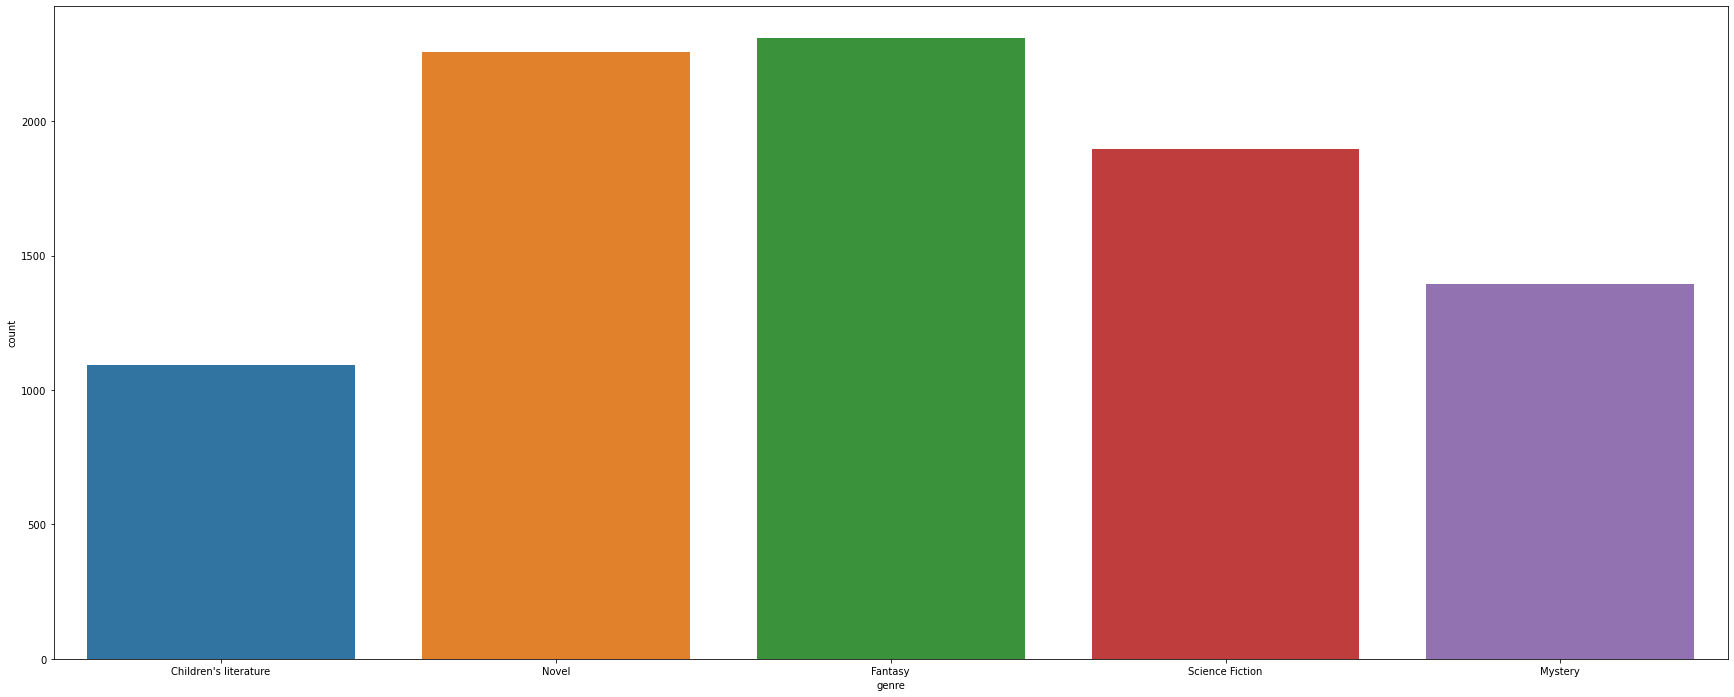

In [17]:
plt.figure(figsize=(30,12))
sns.countplot(genre_books['genre'])

In [18]:
train, test = train_test_split(genre_books, test_size=0.2, random_state=120)
print(train.shape[0])
print(test.shape[0])

7163
1791


In [19]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=100,token_pattern=r'(?u)\b[A-Za-z]+\b',strip_accents='ascii')
X_train_text = text_transformer.fit_transform(train['summary'])
X_test_text = text_transformer.transform(test['summary'])

In [20]:
logistic = LogisticRegression(C=10, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
s_k_f = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [21]:
cross_val=cross_val_score(logistic, X_train_text, train['genre'], cv=s_k_f , scoring='f1_micro')


In [22]:
logistic.fit(X_train_text, train['genre'])

LogisticRegression(C=10, multi_class='multinomial', n_jobs=4, random_state=17)

In [23]:
import eli5

eli5.show_weights(estimator=logistic,feature_names= list(text_transformer.get_feature_names()),top=(10,10))

As it can be observed from the above output, eli5 shows us the contribution of each feature in predicting the output. If you further wish to see and compare what combination of features and values lead to a particular prediction, we can use show_prediction().

In [24]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
genre_books["genre_no"] = label_encoder.fit_transform(genre_books["genre"])  
genre_books["genre_no"].unique()

array([0, 3, 1, 4, 2])

In [25]:
from sklearn.preprocessing import LabelEncoder 
lab = LabelEncoder()

In [26]:
lab.fit(list(genre_books['genre'].values))
gen_name = list(lab.inverse_transform([0,1,2,3,4]))
gen_name

["Children's literature", 'Fantasy', 'Mystery', 'Novel', 'Science Fiction']

Assigining the numbers to the main genere types

In [27]:
genre_books[genre_books["genre_no"] == 4].summary

8         Living on Mars, Deckard is acting as a consul...
9         Beginning several months after the events in ...
21        Nine years after Emperor Paul Muad'dib walked...
23        The situation is desperate for the Bene Gesse...
35        On a rainy night while returning from his job...
                               ...                        
16427     The Stories of Ibis begins with a wandering s...
16429     "Suppose you were murdered and then woke up 3...
16448     A clan of "free miners" living on the spacesh...
16515     Briareus Delta becomes a supernova only about...
16549     The story starts with former government agent...
Name: summary, Length: 1897, dtype: object

In [28]:
import nltk
nltk.download("stopwords")
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=10000)
X = vectorizer.fit_transform(genre_books.summary).toarray()
print(X.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\about\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(8954, 10000)


In [29]:
X_train,X_test, y_train,y_test = train_test_split(X,genre_books['genre_no'],test_size=0.2, random_state=143)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7163, 10000)
(7163,)
(1791, 10000)
(1791,)


## Model Evaluation

Finally, evaluate and compare the learned predictive models.

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
new = []
models = [('LogReg', LogisticRegression()),
          ('RF', RandomForestClassifier()),
          ('DTC',DecisionTreeClassifier())
          ]
        

In [32]:
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
target_names = ['malignant', 'benign']
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=1254)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred))
        results.append(cv_results)
        names.append(name)
        newdf = pd.DataFrame(cv_results)
        newdf['model'] = name
        new.append(newdf)
        finaldf = pd.concat(new, ignore_index=True)

LogReg
              precision    recall  f1-score   support

           0       0.68      0.42      0.52       242
           1       0.75      0.77      0.76       485
           2       0.77      0.72      0.74       274
           3       0.60      0.76      0.67       427
           4       0.74      0.73      0.74       363

    accuracy                           0.70      1791
   macro avg       0.71      0.68      0.69      1791
weighted avg       0.71      0.70      0.70      1791

RF
              precision    recall  f1-score   support

           0       0.63      0.19      0.29       242
           1       0.65      0.73      0.69       485
           2       0.74      0.57      0.64       274
           3       0.49      0.72      0.59       427
           4       0.69      0.63      0.66       363

    accuracy                           0.61      1791
   macro avg       0.64      0.57      0.57      1791
weighted avg       0.63      0.61      0.60      1791

DTC
        

In [33]:
bootstraps = []
for model in list(set(finaldf.model.values)):
    model_df = finaldf.loc[finaldf.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] 

results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)]
results_long_nofit = results_long_nofit.sort_values(by='values')

results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] 
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

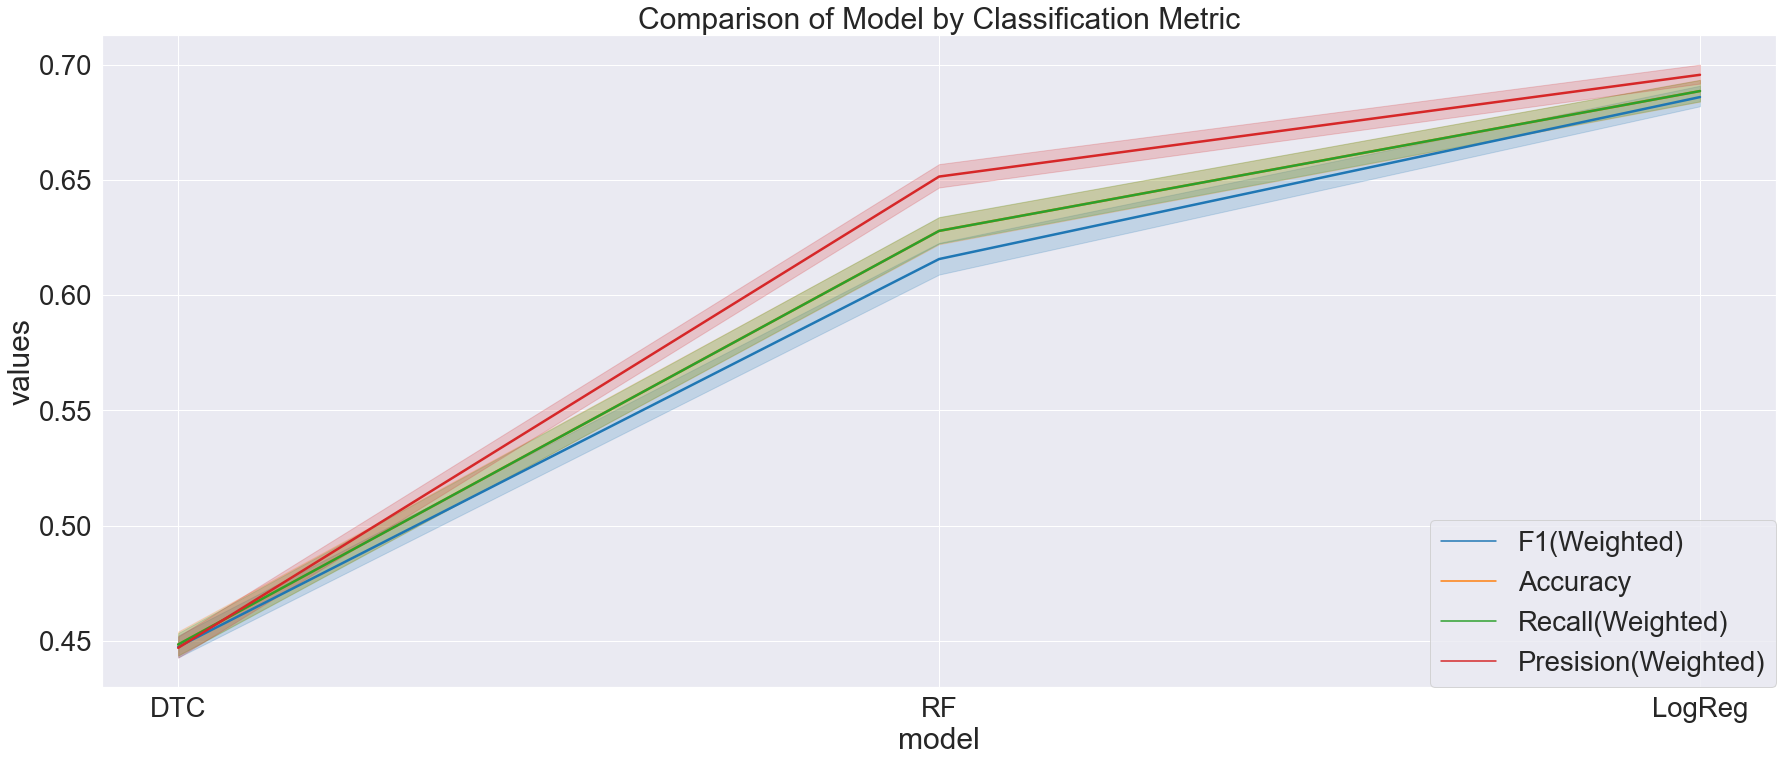

In [34]:
plt.figure(figsize=(30,12))
sns.set(font_scale=2.5)
results_long_nofit = results_long_nofit.replace(['test_precision_weighted','test_f1_weighted','test_recall_weighted','test_accuracy'], ['Presision(Weighted)','F1(Weighted)','Recall(Weighted)','Accuracy'])
g = sns.lineplot(x="model", y="values", hue="metrics", data=results_long_nofit,  palette="tab10",linewidth=2.5)
plt.legend( loc=4, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

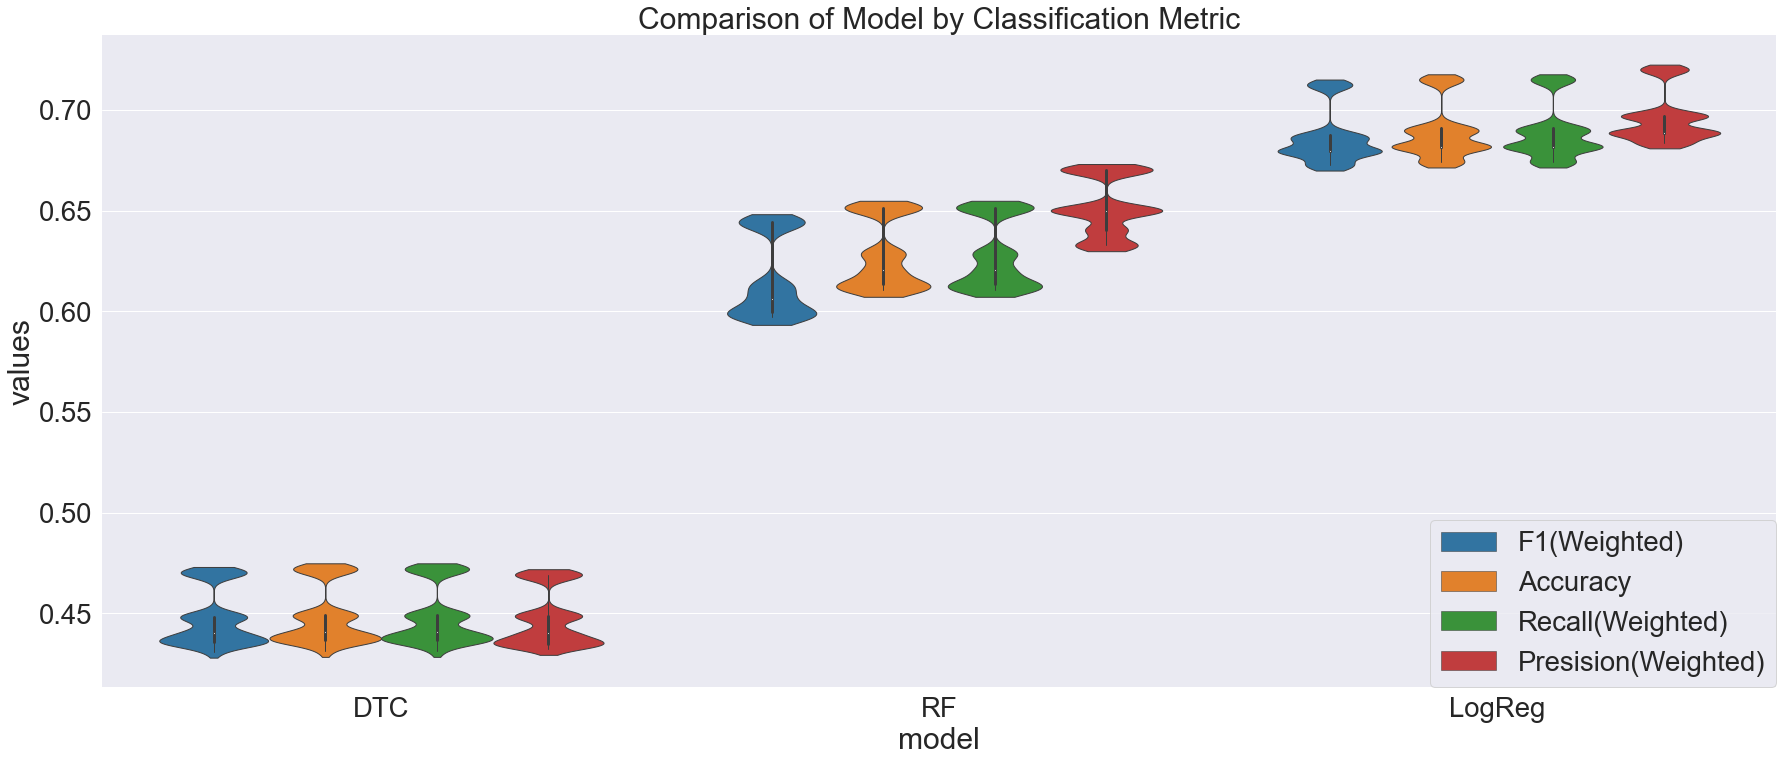

In [35]:
plt.figure(figsize=(30,12))
sns.set(font_scale=2.5)
results_long_nofit = results_long_nofit.replace(['test_precision_weighted','test_f1_weighted','test_recall_weighted','test_accuracy'], ['Presision(Weighted)','F1(Weighted)','Recall(Weighted)','Accuracy'])
g = sns.violinplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="tab10", bw=.2, cut=1, linewidth=1)
plt.legend( loc=4, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
sns.despine(left=True, bottom=True)

#### Observations
In above graph we can see that Logestic Regression performed the best followed by the Random Forest and lastly the decision tree classifier, here we have used Accuracy score ,Presision weighted ,Recall(weighted),F1(weighted).All 3 model yeils a good outcome in the predicion of the genere from the summary.